# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | LEMARCHANT HUGO - AP85480 | NOMS - CODE PERMANENT       |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | AUTOMNE 2018                                            |
| Groupe                | C                                                       |
| Numéro du laboratoire | 1                                                       |
| Professeur            | Prof. Hervé Lombaert                                    |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 2018/09/27                                              |

In [72]:
# -*- coding:utf-8 -*-
import numpy as np
import cv2
import core
import matplotlib.pyplot as plt
import sys
import numpy as np
import os, random
import cv2

In [77]:
# Hugo
path = "E:\\DocsPerso\\DocsBoulot\\ETS-MTL\\GTI770-02-SystIntel&MachineLearning\\data\\data\\images\\"
# JS
path= '/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/'
exts = ".jpg"
nb_img = "100520"

path = path + nb_img + exts

GP=core.GalaxyProcessor(path)

### Feature #1 ratio_aspect

In [78]:
def get_ratio_aspect(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img,50,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 2, 2)
    rect = []
    for cnt in contours:
        rect.append(cv2.minAreaRect(cnt))
    bestRect = max(rect, key = lambda rect : rect[1][0]*rect[1][1])
    box = cv2.boxPoints(bestRect)
    box = np.int0(box)
    cv2.drawContours(img,[box],0,(0,0,255),2)
    ratio = bestRect[1][0]/(bestRect[1][1]+0.0000000001)
    print("ratio = {}".format(ratio))
    return bestRect[1][0]/(bestRect[1][1]+0.0000000001)

ratio = get_ratio_aspect(path)

ratio = 0.2600791276108834


### Feature #2 CCV

In [185]:
def QuantizeColor(img, N=64):
    
    div = 256//N
    rgb = cv2.split(img)
    quantized_list = []
    
    # quantize N colors for each channel
    for ch in rgb:
        vf = np.vectorize(lambda x, div: int(x//div)*div)
        quantized = vf(ch, div)
        quantized_list.append(quantized.astype(np.uint8))
    
    # Merge the channels after quantization
    d_img = cv2.merge(quantized_list)
    
    return d_img

def plt_display(title,img):
    
    print('image: {0} shape: {1}'.format(title,img.shape))
    plt.imshow(img)
    plt.title(title)
    plt.show() 
    
def get_ccv(src,Threshold,N,prt=False):
    
    img = src.copy()
    if prt:
        plt_display('Original image',img)
    
    (row, col, channels) = img.shape
    #print('shape : {0},{1},{2}'.format(row, col, channels))

    # blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    if prt:
        plt_display('After blur',img)

    # quantize color

    img = QuantizeColor(img, N)
    if prt:
        plt_display('After Quantization',img)
    
    bgr = cv2.split(img)
    #print('b={0},g={1},r={2}'.format(len(bgr[0]),len(bgr[1]),len(bgr[2])))

    # bgr = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))    
    alpha = np.zeros(N)
    beta = np.zeros(N)

    # labeling
    for (i, ch) in enumerate(bgr):
        (ret, th) = cv2.threshold(ch, 127, 255, 0)
        
        if prt:
            plt_display('after threshold',img)   
    
        (ret, labeled, stat, centroids) = cv2.connectedComponentsWithStats(th, None,cv2.CC_STAT_AREA, None, connectivity=8)

        # generate ccv
        print('stat : {0}'.format(stat.shape))
        areas = [[v[4], label_idx] for (label_idx, v) in enumerate(stat)]
        coord = [[v[0], v[1]] for (label_idx, v) in enumerate(stat)]

        # Counting coherent and incoherent pixels
        for (a, c) in zip(areas, coord):
            area_size = a[0]
            (x, y) = (c[0], c[1])
            
            if x < ch.shape[1] and y < ch.shape[0]:
                bin_idx = int(ch[y, x] // (256 // N))
                if area_size >= Threshold:
                    # COHERENT PIXELS (belong to area > Threshold pixels )
                    alpha[bin_idx]+= area_size
                else:
                    # INCOHERENT PIXELS (belong to area <= Threshold pixels )
                    beta[bin_idx]+= area_size
    
    return (alpha, beta)

def ccv_plot(img,alpha,beta,N):

    X = [x for x in range(N * 2)]
    Y = alpha.tolist() + beta.tolist()

    with open('ccv.csv', 'w') as f:
        f.write(str(Y))
    
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 1, 1)
    plt.imshow(im)
    plt.subplot(2, 1, 2)
    plt.bar(X, Y, align='center')

    plt.yscale('log')
   
    plt.show()

stat : (2, 5)
stat : (2, 5)
stat : (1, 5)


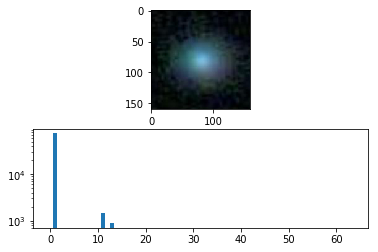

In [188]:
path='/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/'
filename=random.choice(os.listdir(path))
img = cv2.imread('{0}{1}'.format(path,filename))
im_color=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_cropped=GP.crop_image(im_color, 212-80, 212+80)
#plt_display('image cropped 160x160',im_cropped)   
#im_grey=cv2.cvtColor(img.astype("uint8"), cv2.COLOR_BGR2GRAY)

N=32
coherence_threshold_percent=0.01
alpha, beta = get_ccv(im_cropped, Threshold=im_cropped.shape[0]**2*coherence_threshold_percent,N=N,prt=False)
#print('{0},{1}'.format(alpha, beta))
CCV = alpha.tolist()+beta.tolist()
assert(sum(CCV) == im_cropped.size)
assert(N == len(alpha) and N == len(beta))

ccv_plot(im_cropped, alpha, beta, N)

Introduction et revue de la littérature

### Question 2

### Question 3

### Question 4

### Question 5

### Conclusion

### Bibliographie